In [36]:
import numpy as np
import pandas as pd

In [38]:
import matplotlib.pyplot as plt

In [39]:
!pip install seaborn

     -------------------------------------- 293.3/293.3 kB 1.6 MB/s eta 0:00:00


In [40]:
import seaborn as sns

In [41]:
sns.set()

In [42]:
!pip install yfinance --upgrade --no-cache-dir

     -------------------------------------- 62.5/62.5 kB 479.0 kB/s eta 0:00:00
     ---------------------------------------- 3.8/3.8 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 2.6/2.6 MB 2.7 MB/s eta 0:00:00
     -------------------------------------- 112.2/112.2 kB 2.2 MB/s eta 0:00:00


In [45]:
!pip install pandas_datareader

     ------------------------------------ 109.5/109.5 kB 902.0 kB/s eta 0:00:00


In [46]:
import pandas_datareader
from pandas_datareader import data as pdr

In [48]:
!pip install fix_yahoo_finance 

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for fix_yahoo_finance: filename=fix_yahoo_finance-0.1.37-py3-none-any.whl size=7090 sha256=e4cd8ca4cadcbc9c12a6cf0fb6ff26d79d760c479838286495ee6163dd16fd60
  Stored in directory: c:\users\91636\appdata\local\pip\cache\wheels\1a\41\80\6cd5c10b88a3546cbe4cb412633ef2d12906510c403f723676
Successfully built fix_yahoo_finance


In [50]:
!pip install yfinance

In [51]:
import yfinance as yf

In [52]:
from collections import deque

In [53]:
import random
import tensorflow.compat.v1 as tf

In [55]:
tf.disable_eager_execution()

In [100]:
yf.pdr_override()
df_full = pdr.get_data_yahoo("WIPRO.BO", start="2018-01-01").reset_index()
print(df_full)

[*********************100%***********************]  1 of 1 completed
           Date        Open        High         Low       Close   Adj Close  \
0    2018-01-01  235.050003  239.887497  232.050003  238.312500  237.726746   
1    2018-01-02  236.250000  242.812500  236.024994  239.175003  238.587128   
2    2018-01-03  240.000000  240.000000  231.412506  232.649994  232.078156   
3    2018-01-04  232.462494  234.300003  230.625000  233.625000  233.050766   
4    2018-01-05  235.500000  235.500000  230.850006  232.312500  231.741501   
...         ...         ...         ...         ...         ...         ...   
1333 2023-06-05  406.850006  409.600006  404.000000  404.299988  404.299988   
1334 2023-06-06  404.000000  404.000000  395.700012  399.899994  399.899994   
1335 2023-06-07  402.000000  403.600006  401.049988  402.799988  402.799988   
1336 2023-06-08  404.000000  404.649994  398.700012  399.500000  399.500000   
1337 2023-06-09  399.500000  400.299988  396.100006  397.85000

In [101]:
df_full.to_csv("WIPRO.BO.csv",index=False)
df_full.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-01,235.050003,239.887497,232.050003,238.312500,237.726746,232883
1,2018-01-02,236.250000,242.812500,236.024994,239.175003,238.587128,273486
2,2018-01-03,240.000000,240.000000,231.412506,232.649994,232.078156,266310
3,2018-01-04,232.462494,234.300003,230.625000,233.625000,233.050766,220961
4,2018-01-05,235.500000,235.500000,230.850006,232.312500,231.741501,248015


In [102]:
df= df_full.copy()
name = 'Q-learning agent'
class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen = 1000)
        self.inventory = []
        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999
        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 256, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())
    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return cost
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.get_state(t + 1)
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= self.trend[t]
                elif action == 2 and len(inventory) > 0:
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                invest = ((starting_money - initial_money) / initial_money)
                self.memory.append((state, action, invest, 
                                    next_state, starting_money < initial_money))
                state = next_state
                batch_size = min(self.batch_size, len(self.memory))
                cost = self.replay(batch_size)
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [103]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32


In [104]:
agent = Agent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip, 
              batch_size = batch_size)
agent.train(iterations = 100, checkpoint = 20, initial_money = initial_money)

C:\Users\91636\.conda\envs\hack\lib\site-packages\tensorflow\python\client\session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


epoch: 20, total rewards: -144.912506.3, cost: 0.121412, total money: 9855.087494
epoch: 40, total rewards: -35.925018.3, cost: 0.078552, total money: 9964.074982
epoch: 60, total rewards: -63.750076.3, cost: 0.087782, total money: 9936.249924
epoch: 80, total rewards: -51.150024.3, cost: 0.053263, total money: 9948.849976
epoch: 100, total rewards: -75.812500.3, cost: 0.047514, total money: 9924.187500


In [105]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 238.312500, total balance 9761.687500
day 1, sell 1 unit at price 239.175003, investment 0.361921 %, total balance 10000.862503,
day 15: buy 1 unit at price 240.600006, total balance 9760.262497
day 18, sell 1 unit at price 233.962494, investment -2.758733 %, total balance 9994.224991,
day 34: buy 1 unit at price 218.512497, total balance 9775.712494
day 36: buy 1 unit at price 219.300003, total balance 9556.412491
day 38, sell 1 unit at price 218.925003, investment 0.188779 %, total balance 9775.337494,
day 39, sell 1 unit at price 219.300003, investment 0.000000 %, total balance 9994.637497,
day 40: buy 1 unit at price 219.600006, total balance 9775.037491
day 41, sell 1 unit at price 219.000000, investment -0.273227 %, total balance 9994.037491,
day 42: buy 1 unit at price 217.912506, total balance 9776.124985
day 45, sell 1 unit at price 213.750000, investment -1.910173 %, total balance 9989.874985,
day 50: buy 1 unit at price 219.937500, total balance 97

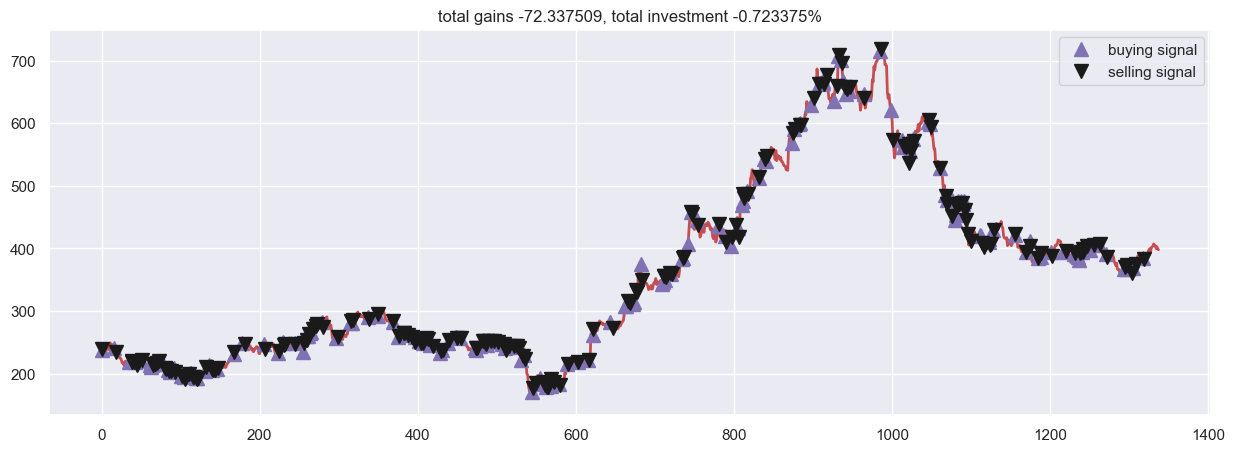

In [106]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.savefig(name+'.png')
plt.show()